### Objective
Build the model to predict fuel prices in Italy.
### Data Description
Weekly fuel prices in Italy from 03/2005 to 08/2021.

In [1]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from download import download
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_absolute_error, mean_squared_error

C:\Users\kagir\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\kagir\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
fuel_prices = pd.read_csv("weekly_fuel_prices_all_data_from_2005_to_20210823.csv")
fuel_prices

,SURVEY_DATE,PRODUCT_ID,PRODUCT_NAME,PRICE,VAT,EXCISE,NET,CHANGE
0,2005-01-03,1,Euro-Super 95,1115.75,185.96,558.64,371.15,-1.57
1,2005-01-03,2,Automotive gas oil,1018.28,169.71,403.21,445.36,-0.33
2,2005-01-03,3,Heating gas oil,948.50,158.08,403.21,387.21,-22.55
3,2005-01-03,5,LPG,552.50,92.08,156.62,303.80,0.22
4,2005-01-03,6,Residual fuel oil,553.25,50.30,166.84,336.11,-12.21
...,...,...,...,...,...,...,...,...
4975,2021-08-16,2,Automotive gas oil,1507.75,271.89,617.40,618.46,-2.23
4976,2021-08-16,3,Heating gas oil,1287.96,232.26,403.21,652.49,-2.93
4977,2021-08-16,5,LPG,695.35,125.39,147.27,422.69,3.08
4978,2021-08-16,6,Residual fuel oil,825.45,75.04,166.84,583.57,0.72


In [3]:
fuel_prices.isnull().sum()

SURVEY_DATE     0
PRODUCT_ID      0
PRODUCT_NAME    0
PRICE           0
VAT             0
EXCISE          0
NET             0
CHANGE          0
dtype: int64

In [4]:
fuel_prices.duplicated().sum()

0

In [5]:
fuel_prices.shape

(4980, 8)

In [6]:
fuel_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4980 entries, 0 to 4979
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SURVEY_DATE   4980 non-null   object 
 1   PRODUCT_ID    4980 non-null   int64  
 2   PRODUCT_NAME  4980 non-null   object 
 3   PRICE         4980 non-null   float64
 4   VAT           4980 non-null   float64
 5   EXCISE        4980 non-null   float64
 6   NET           4980 non-null   float64
 7   CHANGE        4980 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 311.4+ KB


In [7]:
from datetime import date
from datetime import datetime

In [8]:
# convert SURVEY_DATE from object to datetime
fuel_prices.SURVEY_DATE = pd.to_datetime(fuel_prices.SURVEY_DATE)

In [9]:
fuel_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4980 entries, 0 to 4979
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   SURVEY_DATE   4980 non-null   datetime64[ns]
 1   PRODUCT_ID    4980 non-null   int64         
 2   PRODUCT_NAME  4980 non-null   object        
 3   PRICE         4980 non-null   float64       
 4   VAT           4980 non-null   float64       
 5   EXCISE        4980 non-null   float64       
 6   NET           4980 non-null   float64       
 7   CHANGE        4980 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 311.4+ KB


In [10]:
fuel_prices.index = fuel_prices.SURVEY_DATE
df_day= fuel_prices.resample('D').mean()

In [11]:

# Resampling to monthly frequency
df_month = df_day.resample('M').mean()

# Resampling to quarterly frequency
df_Q = df_day.resample('Q-DEC').mean()

# Resampling to annual frequency
df_year = df_day.resample('A-DEC').mean()

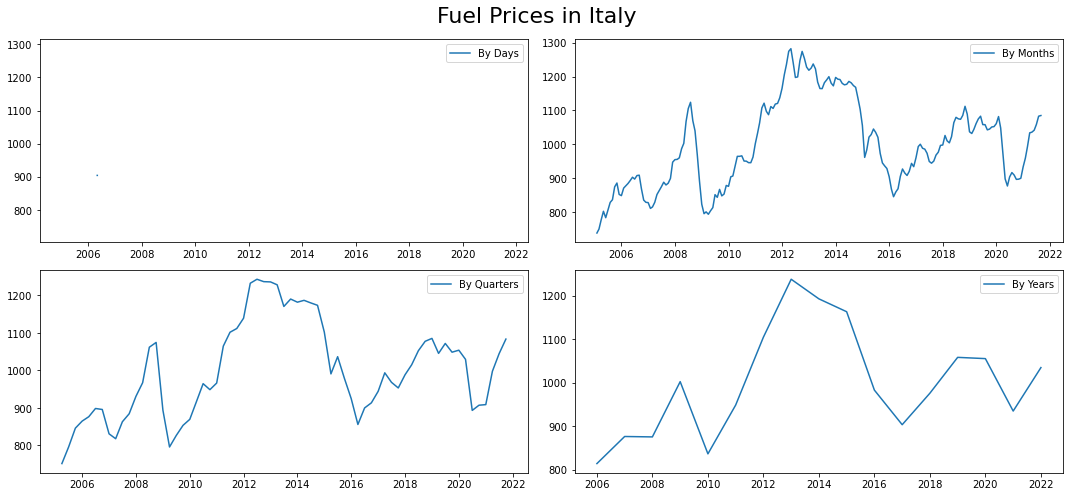

In [12]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Fuel Prices in Italy', fontsize=22)
plt.subplot(221)
plt.plot(df_day.PRICE, '-', label='By Days')
plt.legend()
plt.subplot(222)
plt.plot(df_month.PRICE, '-', label='By Months')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.PRICE, '-', label='By Quarters')
plt.legend()
plt.subplot(224)
plt.plot(df_year.PRICE, '-', label='By Years')
plt.legend()
plt.tight_layout()
plt.show()

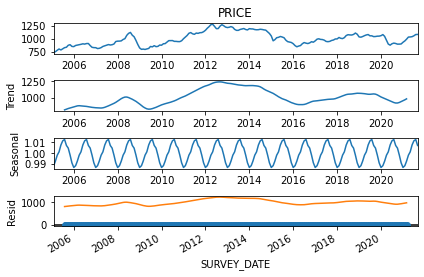

In [13]:
#Decomposition
import statsmodels.api as sm
# res = sm.tsa.seasonal_decompose(bitcoin.Weighted_Price_FFILL, model = 'multiplicative')
# plt.figure(figsize=[15,7])
res = sm.tsa.seasonal_decompose(df_month.PRICE, model = 'multiplicative')
res.plot()
res.trend.plot()

plt.show()


C:\Users\kagir\anaconda3\envs\learn-env\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


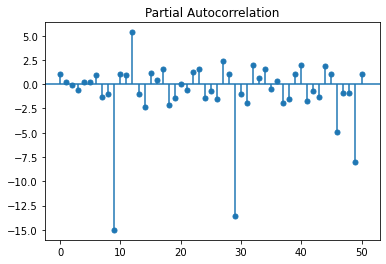

In [14]:
##check for auto correlation
# 
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(fuel_prices['PRICE'], lags = 50)

## Analysis by month

In [15]:
## checking for stationarity
#AD fuller test
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.PRICE)[1])

Dickey–Fuller test: p=0.139735


In [16]:
# checking for stationarity in kpss
print("KPSS: p=%f" % sm.tsa.stattools.kpss(df_month.PRICE, 'c')[1])

KPSS: p=0.097156


C:\Users\kagir\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


In [17]:
### cheking moving averages
# exponential moving average
# weighted moving average
#simple moving average

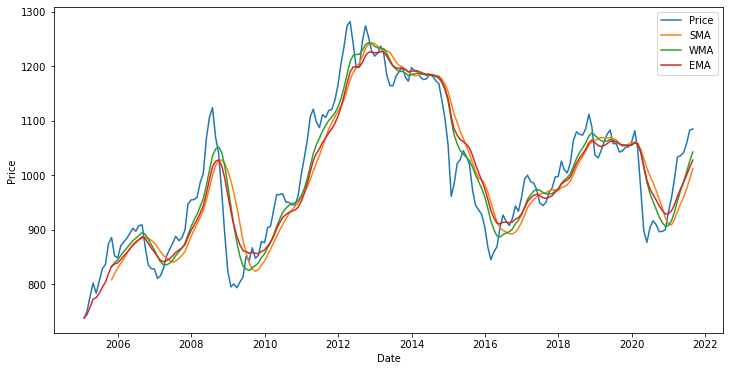

In [18]:
#
import numpy as np
weights = np.arange(1,11) 
wma = df_month['PRICE'].rolling(10).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)
move = df_month.PRICE.rolling(10).mean()
ema = df_month['PRICE'].ewm(span=10).mean()
plt.figure(figsize = (12,6))
plt.plot(df_month['PRICE'], label="Price")
plt.plot(move, label="SMA")
plt.plot(wma, label="WMA")
plt.plot(ema, label="EMA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [19]:
# normalizing data with box cot transformation

In [20]:
from scipy import stats
df_month['Price_box'], lmbda = stats.boxcox(df_month.PRICE)

In [21]:
#Seasonal differentiation

In [22]:
df_month['prices_box_diff'] = df_month.Price_box - df_month.Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.099393


In [23]:
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.099393


<Figure size 1080x504 with 0 Axes>

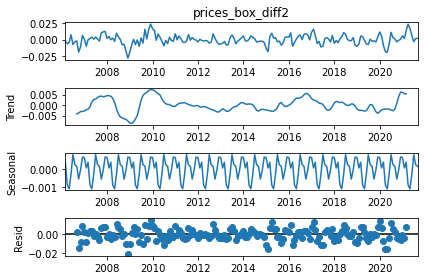

In [24]:
# STL-decomposition
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
plt.show()

In [25]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])


Dickey–Fuller test: p=0.000009


In [26]:
# model selection
# Initial approximation of parameters
from itertools import product
import warnings
warnings.filterwarnings("ignore")
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Price_box, order=(param[0], d, param[1]), 
              seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [27]:
# CODE SECTION
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def eval_metrics(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    R2_score = r2_score(actual, pred)
    print("------------------------------------")
    print(f"R2_score \t: {R2_score}")
    print(f"MAE \t\t: {mae}")
    print(f"MSE \t\t: {mse}")
    print(f"RMSE \t\t: {rmse}")
def evals_():
    print("y_train / y_train_pred ")
    eval_metrics(y_train, y_train_pred)
    #print("y_test / y_test_pred ")
    #eval_metrics(y_test, y_test_pred)
def rms_() :   #  RMS
    trainscore = int(math.sqrt(mean_squared_error(y_train, y_train_pred)))
    print("Train Score: %.f RMSE" % (trainscore))
    #testscore = int(math.sqrt(mean_squared_error(y_test, y_test_pred)))
    #print("Test Score: %.f RMSE" % (testscore))


# Visualising the results
def ploty(real,predicted)  :
    plt.plot(real,      color = 'red' , label = '  Real Price'     )   # Real Stock price
    plt.plot(predicted, color = 'blue', label = '  Predicted Price')
    plt.xlabel('Day') ; plt.ylabel(' Price') ; plt.legend()
    plt.show()
def plot_():
    #ploty(y_train,y_train_pred)    # TRAIN
    ploty(y_test,y_test_pred)    

In [28]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters          aic
25  (1, 1, 0, 1) -1433.559895
21  (1, 0, 1, 1) -1429.155108
13  (0, 2, 0, 1) -1428.422935
37  (2, 0, 0, 1) -1427.799914
45  (2, 1, 1, 1) -1421.125509
                                     SARIMAX Results                                      
Dep. Variable:                          Price_box   No. Observations:                  200
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 720.780
Date:                            Wed, 22 Feb 2023   AIC                          -1433.560
Time:                                    09:46:04   BIC                          -1420.635
Sample:                                01-31-2005   HQIC                         -1428.323
                                     - 08-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------

Dickey–Fuller test:: p=0.000000


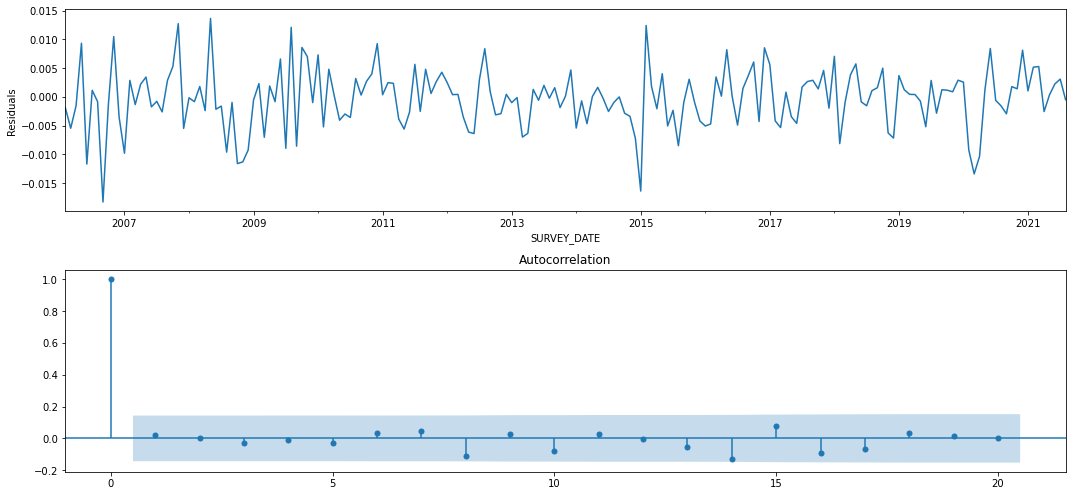

In [29]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=20, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [30]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [31]:
end_=len(df_month)
end_

200

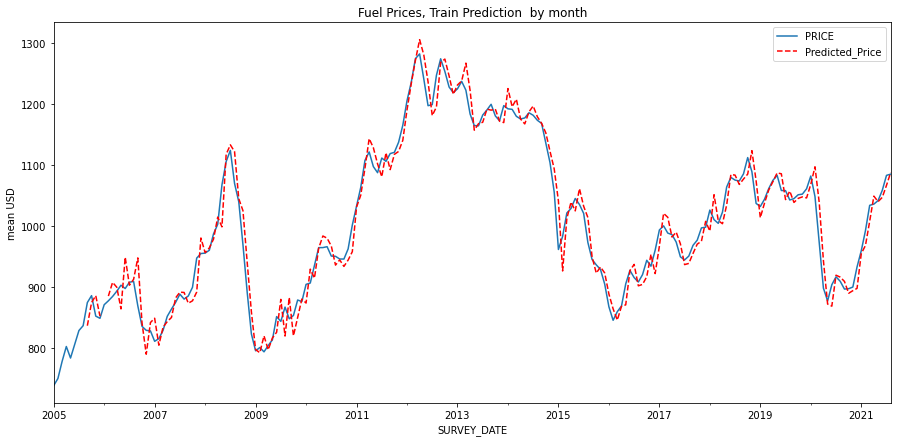

,PRICE,forecast
SURVEY_DATE,,
2005-01-31,737.915000,NaN
2005-02-28,749.522917,NaN
2005-03-31,777.642778,NaN
2005-04-30,802.060833,NaN
2005-05-31,783.142667,NaN
...,...,...
2021-04-30,1035.767500,1048.824550
2021-05-31,1041.486333,1039.785929
2021-06-30,1058.365417,1046.804236


In [32]:
# TRAIN Prediction
month = df_month[['PRICE']]
month['forecast'] = invboxcox(best_model.predict(start=8, end=end_), lmbda)
plt.figure(figsize=(15,7))
month.PRICE.plot()
month.forecast.plot(color='r', ls='--', label='Predicted_Price')
plt.legend()
plt.title('Fuel Prices, Train Prediction  by month')
plt.ylabel('mean USD')
plt.show()
month

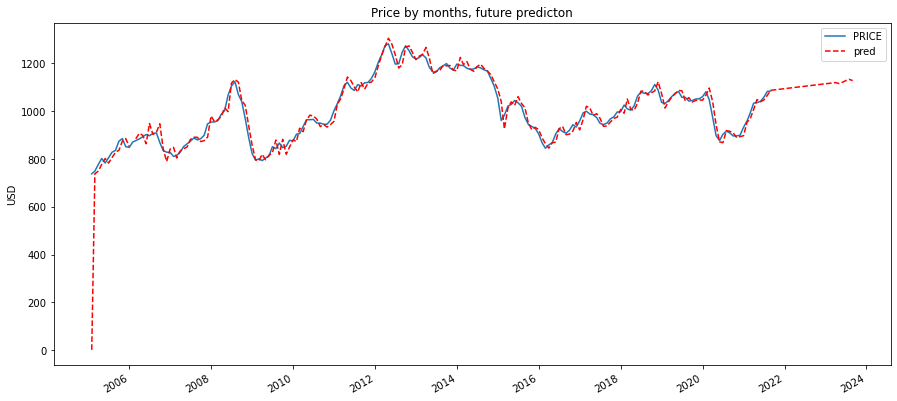

In [33]:
# Prediction
df_month2 = df_month[['PRICE']]
date_list = [datetime(2023, 3, 31), datetime(2023, 4, 30), datetime(2023, 5, 31), datetime(2023, 6, 30), 
             datetime(2023,7, 31), datetime(2023, 8, 31)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=250), lmbda)
plt.figure(figsize=(15,7))
df_month2.PRICE.plot()
df_month2.forecast.plot(color='r', ls='--', label='pred')
plt.legend()
plt.title('Price by months, future predicton')
plt.ylabel('USD')
plt.show()

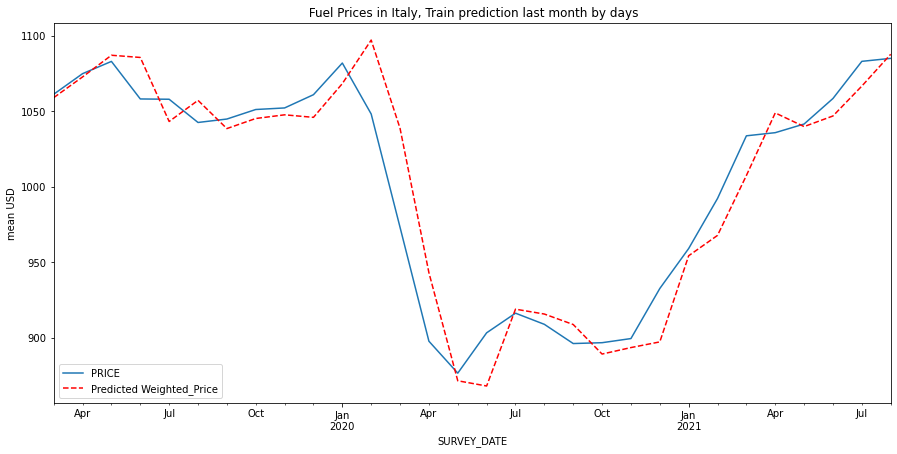

In [34]:
# TRAIN Prediction   Last 30 months of Train prediction
df3= df_month[['PRICE']][-30:]
df3['forecast'] = invboxcox(best_model.predict(start=end_-30, end=end_), lmbda)
plt.figure(figsize=(15,7))
df3.PRICE.plot()
df3.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title(' Fuel Prices in Italy, Train prediction last month by days')
plt.ylabel('mean USD')
plt.show()

In [35]:
# deployment
# model saving
best_model.save("ARIMA_best_month_model.pkl")


df3.to_csv("ARIMA_graph.csv")   #The last 30 days TEST and PRED values
test = df3[["PRICE"]]  #only TEST values
test.to_csv("ARIMA__month_test.csv")

## DAY ANALYSIS

In [36]:
df_day.isnull().sum()

PRODUCT_ID    5240
PRICE         5240
VAT           5240
EXCISE        5240
NET           5240
CHANGE        5240
dtype: int64

In [37]:
df_day['PRODUCT']=df_day['PRODUCT_ID'].fillna(method='ffill')
df_day['PRICE_f']=df_day['PRICE'].fillna(method='ffill')
df_day['VAT_f']=df_day['VAT'].fillna(method='ffill')
df_day['EXCISE_f']=df_day['EXCISE'].fillna(method='ffill')
df_day['NET_f']=df_day['NET'].fillna(method='ffill')
df_day['CHANGE_f']=df_day['CHANGE'].fillna(method='ffill')


In [38]:
df_day.isnull().sum()

PRODUCT_ID    5240
PRICE         5240
VAT           5240
EXCISE        5240
NET           5240
CHANGE        5240
PRODUCT          0
PRICE_f          0
VAT_f            0
EXCISE_f         0
NET_f            0
CHANGE_f         0
dtype: int64

In [39]:
day = df_day.drop(columns=['PRODUCT_ID','PRICE','VAT','EXCISE','NET','CHANGE'])

In [40]:
day = day.dropna(axis=0)

In [41]:
day.isnull().sum()

PRODUCT     0
PRICE_f     0
VAT_f       0
EXCISE_f    0
NET_f       0
CHANGE_f    0
dtype: int64

<Figure size 1080x504 with 0 Axes>

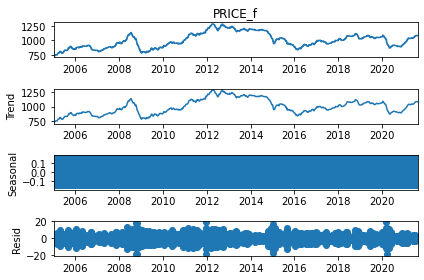

Dickey–Fuller test: p=0.130004


In [42]:
## Stationarity check and STL-decomposition of the series
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(day.PRICE_f).plot()
plt.show()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(day.PRICE_f)[1])
# plt.savefig('decomposition')

In [43]:
## Box-Cox Transformations
# Box-Cox Transformations
day['Price_box'], lmbda = stats.boxcox(day.PRICE_f)
day.head(2)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(day.Price_box)[1])

Dickey–Fuller test: p=0.098682


In [44]:
## Seasonal differentiation
# Seasonal differentiation
day['prices_box_diff'] = day.Price_box - day.Price_box.shift(7)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(day.prices_box_diff[7:])[1])

Dickey–Fuller test: p=0.000000


In [45]:
## Regular differentiation
# Regular differentiation
day['prices_box_diff2'] = day.prices_box_diff - day.prices_box_diff.shift(1)
day.head(10)

,PRODUCT,PRICE_f,VAT_f,EXCISE_f,NET_f,CHANGE_f,Price_box,prices_box_diff,prices_box_diff2
SURVEY_DATE,,,,,,,,,
2005-01-03,4.166667,736.300,109.355000,286.651667,340.293333,-6.968333,3.483401,NaN,NaN
2005-01-04,4.166667,736.300,109.355000,286.651667,340.293333,-6.968333,3.483401,NaN,NaN
2005-01-05,4.166667,736.300,109.355000,286.651667,340.293333,-6.968333,3.483401,NaN,NaN
2005-01-06,4.166667,736.300,109.355000,286.651667,340.293333,-6.968333,3.483401,NaN,NaN
2005-01-07,4.166667,736.300,109.355000,286.651667,340.293333,-6.968333,3.483401,NaN,NaN
2005-01-08,4.166667,736.300,109.355000,286.651667,340.293333,-6.968333,3.483401,NaN,NaN
2005-01-09,4.166667,736.300,109.355000,286.651667,340.293333,-6.968333,3.483401,NaN,NaN
2005-01-10,4.166667,730.915,108.198333,286.651667,336.065000,-5.385000,3.481680,-0.001721,NaN
2005-01-11,4.166667,730.915,108.198333,286.651667,336.065000,-5.385000,3.481680,-0.001721,0.0


<Figure size 1080x504 with 0 Axes>

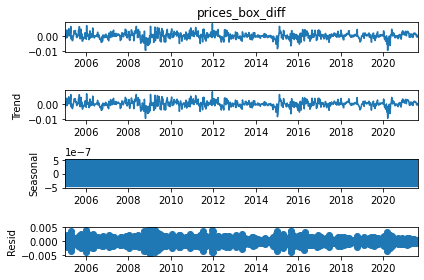

In [46]:
# STL-decomposition
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(day.prices_box_diff[7:]).plot()   
plt.show()

<Figure size 1080x504 with 0 Axes>

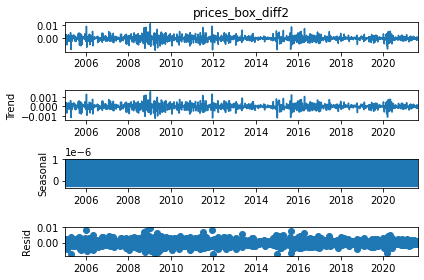

In [47]:
# STL-decomposition
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(day.prices_box_diff2[8:]).plot()   
plt.show()

<Figure size 1080x504 with 0 Axes>

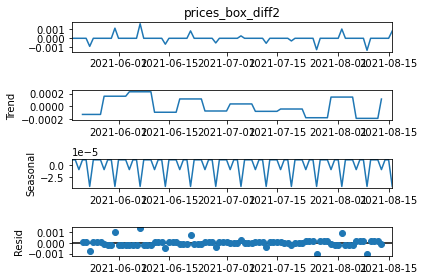

In [48]:
# STL-decomposition  # Last 90 days 
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(day.prices_box_diff2[-90:]).plot()   
plt.show()

<Figure size 1080x504 with 0 Axes>

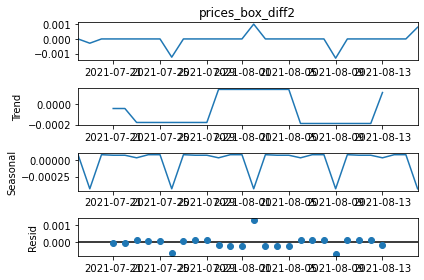

In [49]:
# STL-decomposition  # Last 30 days 
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(day.prices_box_diff2[-30:]).plot()   
plt.show()

In [50]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(day.prices_box_diff2[8:])[1])

Dickey–Fuller test: p=0.000000


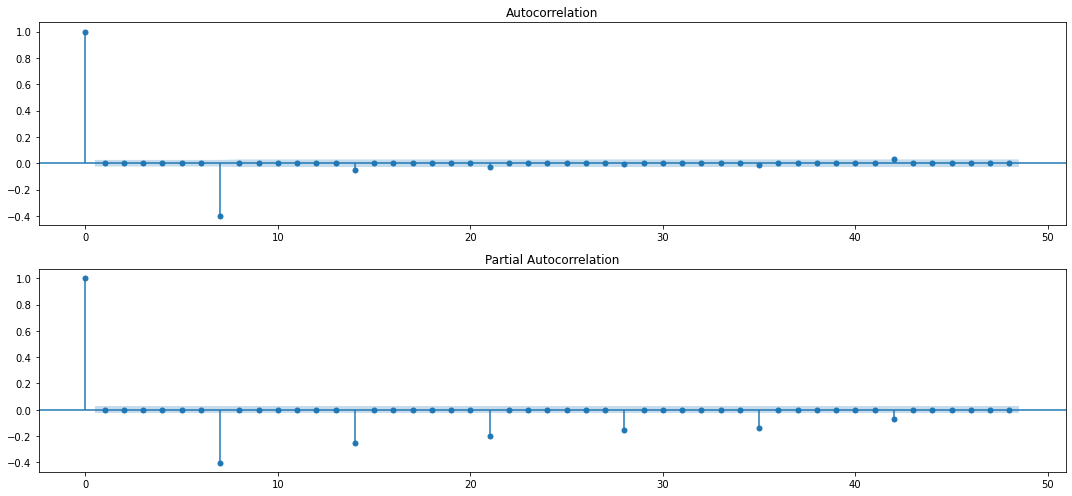

In [51]:
## ACF Autocorrelation Function Plot
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(day.prices_box_diff2[8:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(day.prices_box_diff2[8:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [52]:
## Model Selection
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(day.Price_box, order=(param[0], d, param[1]), 
              seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        bestmodel = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [53]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(bestmodel.summary())

      parameters           aic
5   (0, 0, 2, 1) -69661.545977
11  (0, 1, 2, 1) -69659.545122
23  (1, 0, 2, 1) -69659.545120
29  (1, 1, 2, 1) -69657.545122
41  (2, 0, 2, 1) -69657.545120
                                      SARIMAX Results                                      
Dep. Variable:                           Price_box   No. Observations:                 6070
Model:             SARIMAX(0, 1, 0)x(2, 1, [1], 7)   Log Likelihood               34834.773
Date:                             Wed, 22 Feb 2023   AIC                         -69661.546
Time:                                     09:54:52   BIC                         -69634.707
Sample:                                 01-03-2005   HQIC                        -69652.230
                                      - 08-16-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]

Dickey–Fuller test:: p=0.000000


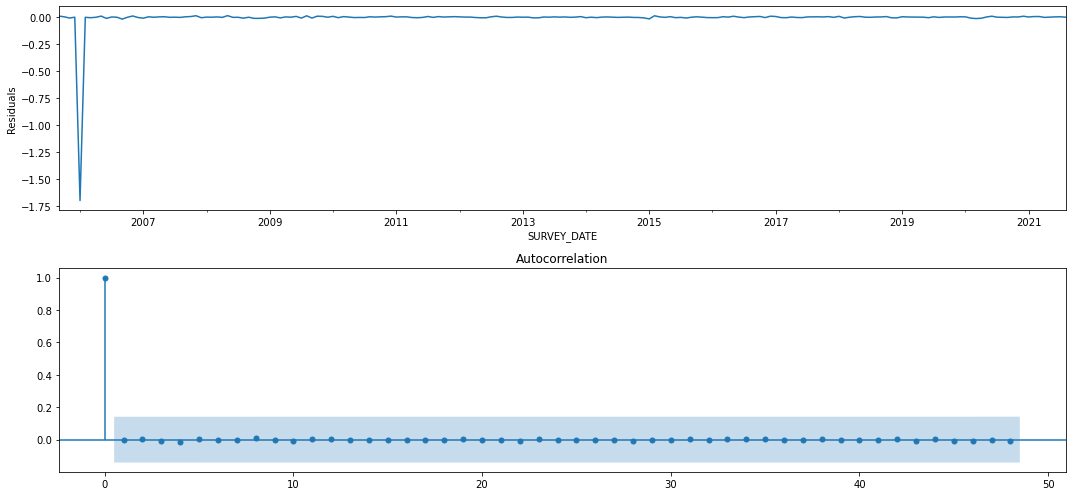

In [54]:
## Analysis of residues
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[8:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[8:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [55]:
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


In [56]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [57]:
end_=len(day)
end_

6070

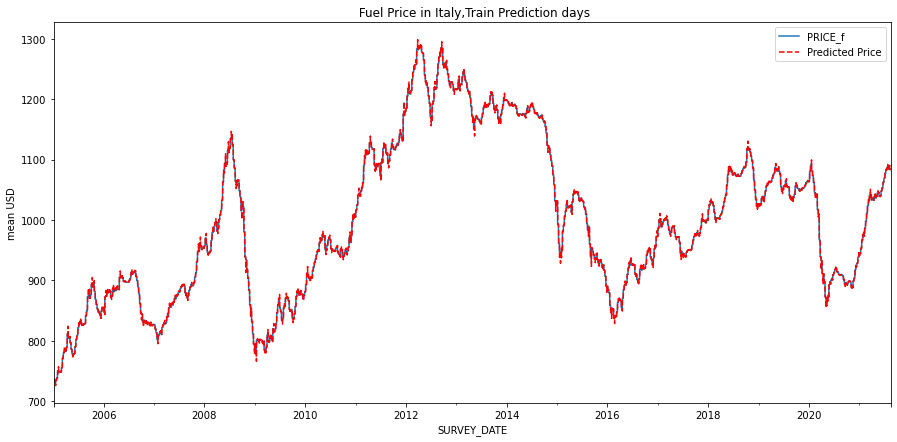

In [58]:
# TRAIN Prediction
df2 = day[['PRICE_f']]
df2['forecast'] = invboxcox(bestmodel.predict(start=4, end=end_), lmbda)
plt.figure(figsize=(15,7))
df2.PRICE_f.plot()
df2.forecast.plot(color='r', ls='--', label='Predicted Price')
plt.legend()
plt.title(' Fuel Price in Italy,Train Prediction days')
plt.ylabel('mean USD')
plt.show()

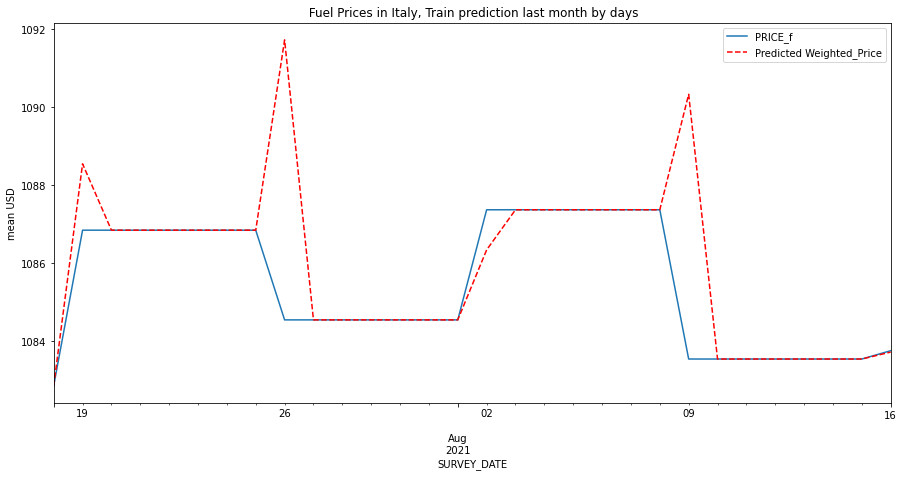

In [59]:
# TRAIN Prediction   Last 30 days of Train prediction
df3= df_day[['PRICE_f']][-30:]
df3['forecast'] = invboxcox(bestmodel.predict(start=end_-30, end=end_), lmbda)
plt.figure(figsize=(15,7))
df3.PRICE_f.plot()
df3.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title(' Fuel Prices in Italy, Train prediction last month by days')
plt.ylabel('mean USD')
plt.show()

In [60]:
y_train=df3.PRICE_f
y_train_pred=df3.forecast
evals_()

y_train / y_train_pred 
------------------------------------
R2_score 	: -0.2666151389317617
MAE 		: 0.5577938424745678
MSE 		: 3.385821390755021
RMSE 		: 1.8400601595477852


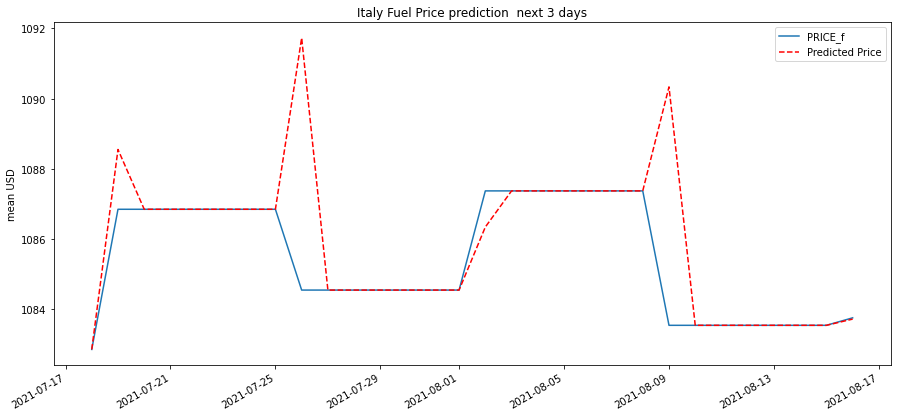

In [61]:
# Prediction  for next 3 days
df4 = day[['PRICE_f']][-30:]
date_list =[datetime(2021, 4,1), datetime(2021,4,2), datetime(2021,4,3)]
future = pd.DataFrame(index=date_list, columns= day.columns)
df4 = pd.concat([df3, future])
df4['forecast'] = invboxcox(bestmodel.predict(start=end_-30, end=end_+30), lmbda)
plt.figure(figsize=(15,7))
df4.PRICE_f.plot()
df4.forecast.plot(color='r', ls='--', label='Predicted Price')
plt.legend()
plt.title('Italy Fuel Price prediction  next 3 days')
plt.ylabel('mean USD')
plt.show()

In [62]:
df4[["PRICE_f","forecast"]].tail(3)   # The last 3 days are forecasted days

,PRICE_f,forecast
2021-04-01,NaN,NaN
2021-04-02,NaN,NaN
2021-04-03,NaN,NaN


In [63]:
dff=df4[["forecast"]].iloc[-30:,]
dff.tail()

,forecast
2021-08-15,1083.546666
2021-08-16,1083.724003
2021-04-01,NaN
2021-04-02,NaN
2021-04-03,NaN


In [64]:
# deployment
# model saving
best_model.save("ARIMA_best_day_model.pkl")


df3.to_csv("ARIMA_day_graph.csv")   #The last 30 days TEST and PRED values

test = df3[["PRICE_f"]]  #only TEST values
test.to_csv("ARIMA_day_test.csv")

## By year

In [65]:
df_year = df_year.resample('Y').mean()


In [66]:
df_year['PRODUCT']=df_year['PRODUCT_ID'].fillna(method='ffill')
df_year['PRICE_f']=df_year['PRICE'].fillna(method='ffill')
df_year['VAT_f']=df_year['VAT'].fillna(method='ffill')
df_year['EXCISE_f']=df_year['EXCISE'].fillna(method='ffill')
df_year['NET_f']=df_year['NET'].fillna(method='ffill')
df_year['CHANGE_f']=df_year['CHANGE'].fillna(method='ffill')

In [67]:
year = df_day.drop(columns=['PRODUCT_ID','PRICE','VAT','EXCISE','NET','CHANGE'])

<Figure size 1080x504 with 0 Axes>

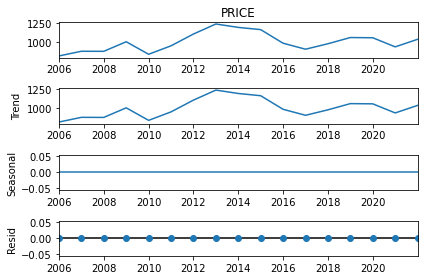

Dickey–Fuller test: p=0.130004


In [68]:
## Stationarity check and STL-decomposition of the series
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_year.PRICE).plot()
plt.show()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(year.PRICE_f)[1])

In [69]:
## Box-Cox Transformations
# Box-Cox Transformations
year['Price_box'], lmbda = stats.boxcox(year.PRICE_f)
year.head(2)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(year.Price_box)[1])

Dickey–Fuller test: p=0.098682


In [70]:
## Seasonal differentiation
# Seasonal differentiation
year['prices_box_diff'] = year.Price_box - year.Price_box.shift(7)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(year.prices_box_diff[7:])[1])

Dickey–Fuller test: p=0.000000


In [71]:
## Regular differentiation
# Regular differentiation
year['prices_box_diff2'] = year.prices_box_diff - year.prices_box_diff.shift(1)
year.head(10)

,PRODUCT,PRICE_f,VAT_f,EXCISE_f,NET_f,CHANGE_f,Price_box,prices_box_diff,prices_box_diff2
SURVEY_DATE,,,,,,,,,
2005-01-03,4.166667,736.300,109.355000,286.651667,340.293333,-6.968333,3.483401,NaN,NaN
2005-01-04,4.166667,736.300,109.355000,286.651667,340.293333,-6.968333,3.483401,NaN,NaN
2005-01-05,4.166667,736.300,109.355000,286.651667,340.293333,-6.968333,3.483401,NaN,NaN
2005-01-06,4.166667,736.300,109.355000,286.651667,340.293333,-6.968333,3.483401,NaN,NaN
2005-01-07,4.166667,736.300,109.355000,286.651667,340.293333,-6.968333,3.483401,NaN,NaN
2005-01-08,4.166667,736.300,109.355000,286.651667,340.293333,-6.968333,3.483401,NaN,NaN
2005-01-09,4.166667,736.300,109.355000,286.651667,340.293333,-6.968333,3.483401,NaN,NaN
2005-01-10,4.166667,730.915,108.198333,286.651667,336.065000,-5.385000,3.481680,-0.001721,NaN
2005-01-11,4.166667,730.915,108.198333,286.651667,336.065000,-5.385000,3.481680,-0.001721,0.0


<Figure size 1080x504 with 0 Axes>

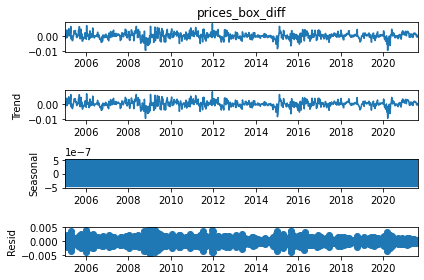

In [72]:
# STL-decomposition
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(year.prices_box_diff[7:]).plot()   
plt.show()

<Figure size 1080x504 with 0 Axes>

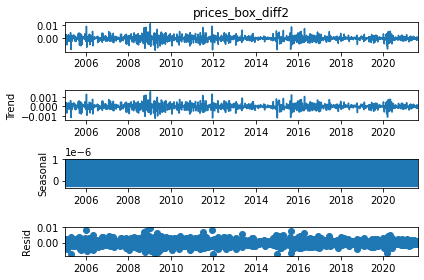

In [73]:
# STL-decomposition
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(year.prices_box_diff2[8:]).plot()   
plt.show()

In [74]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(year.prices_box_diff2[8:])[1])

Dickey–Fuller test: p=0.000000


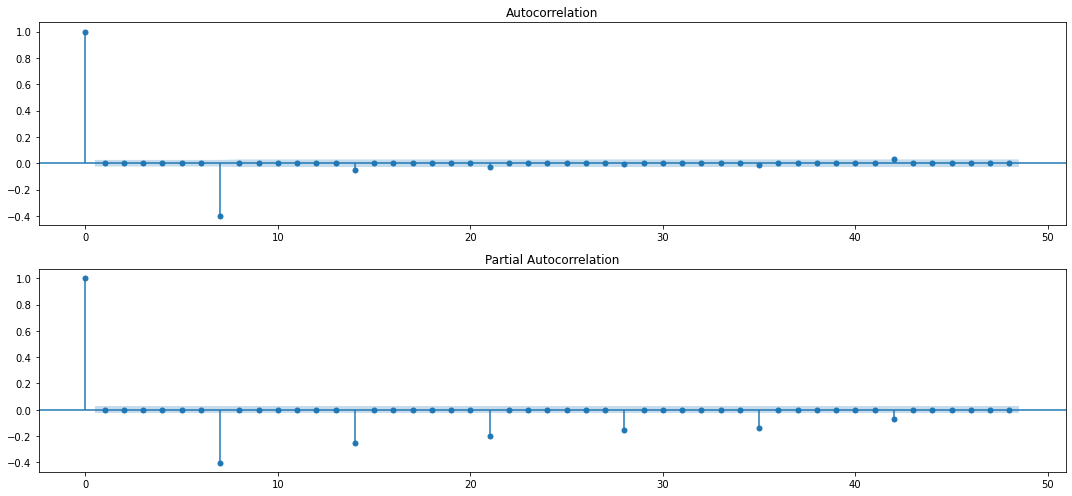

In [75]:
#### The series are stationary.
## ACF Autocorrelation Function Plot
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(year.prices_box_diff2[8:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(year.prices_box_diff2[8:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [76]:
## Model Selection
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(year.Price_box, order=(param[0], d, param[1]), 
              seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model_ = model
        best_aic_ = aic
        best_param_ = param
    results.append([param, model.aic])

In [77]:
# Best Models
result_table_ = pd.DataFrame(results)
result_table_.columns = ['parameters', 'aic']
print(result_table_.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters           aic
5   (0, 0, 2, 1) -69661.545977
11  (0, 1, 2, 1) -69659.545122
23  (1, 0, 2, 1) -69659.545120
29  (1, 1, 2, 1) -69657.545122
41  (2, 0, 2, 1) -69657.545120
                                     SARIMAX Results                                      
Dep. Variable:                          Price_box   No. Observations:                  200
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 720.780
Date:                            Wed, 22 Feb 2023   AIC                          -1433.560
Time:                                    10:04:16   BIC                          -1420.635
Sample:                                01-31-2005   HQIC                         -1428.323
                                     - 08-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------

Dickey–Fuller test:: p=0.000000


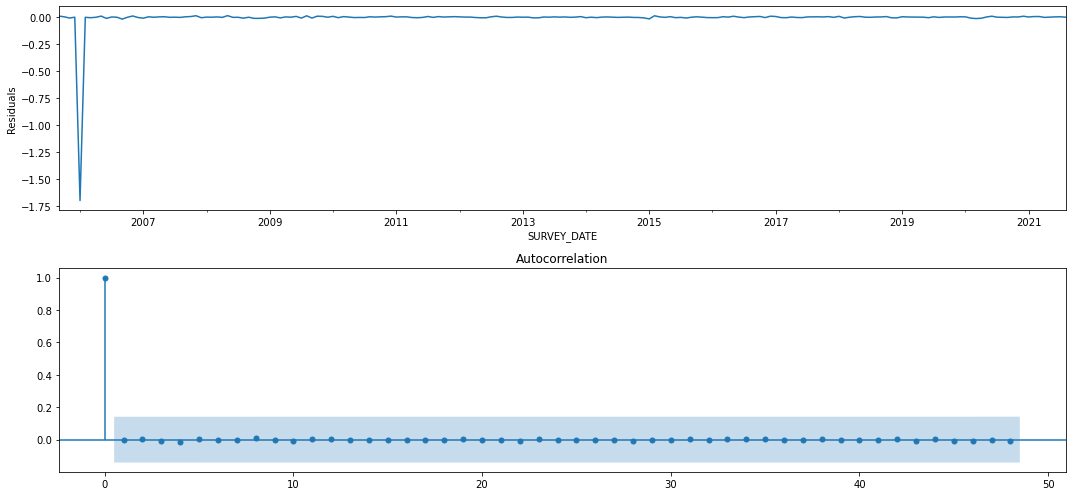

In [78]:
## Analysis of residues
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[8:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[8:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [79]:
len_=len(day)
len_

6070

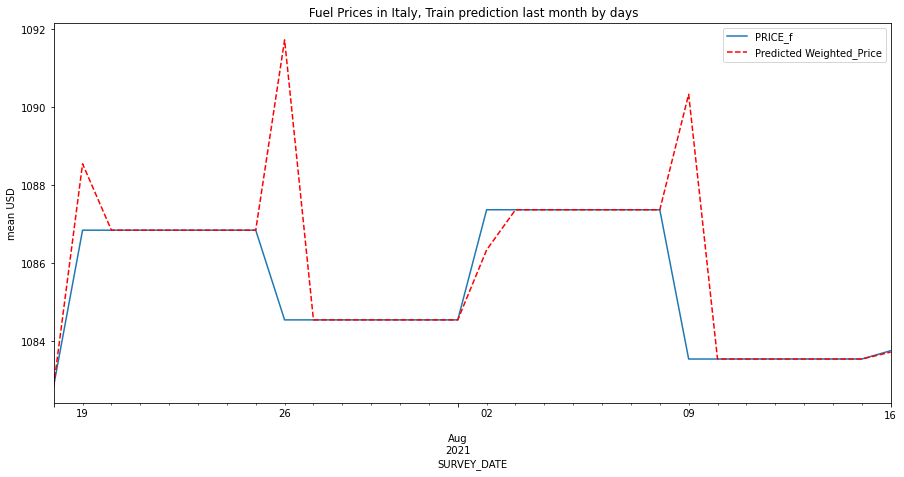

In [80]:
# TRAIN Prediction   Last 30 years of Train prediction
df3= year[['PRICE_f']][-30:]
df3['forecast'] = invboxcox(best_model_.predict(start=end_-30, end=end_), lmbda)
plt.figure(figsize=(15,7))
df3.PRICE_f.plot()
df3.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title(' Fuel Prices in Italy, Train prediction last month by days')
plt.ylabel('mean USD')
plt.show()

In [81]:
y_train=df3.PRICE_f
y_train_pred=df3.forecast
evals_()

y_train / y_train_pred 
------------------------------------
R2_score 	: -0.2666153885730831
MAE 		: 0.5577937666556939
MSE 		: 3.3858220580776357
RMSE 		: 1.8400603408795146


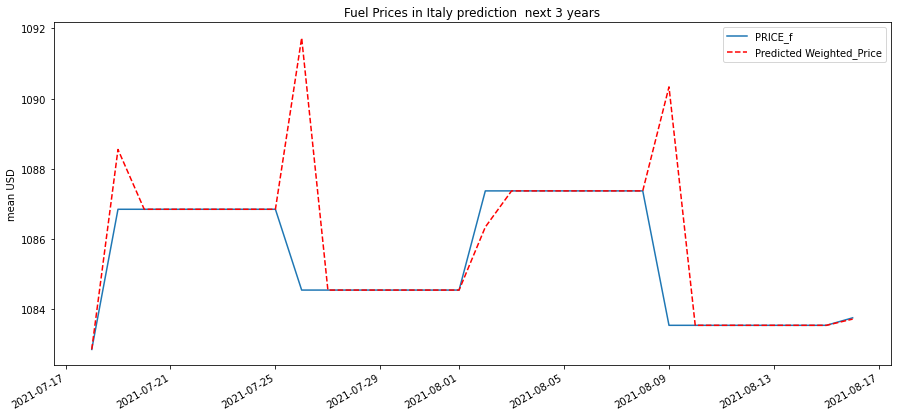

In [82]:
# Prediction  for next 3 years
df4 = year[['PRICE_f']][-30:]
date_list =[datetime(2021, 4,1), datetime(2021,4,2), datetime(2021,4,3)]
future = pd.DataFrame(index=date_list, columns= year.columns)
df4 = pd.concat([df3, future])
df4['forecast'] = invboxcox(best_model_.predict(start=end_-30, end=end_+3), lmbda)
plt.figure(figsize=(15,7))
df4.PRICE_f.plot()
df4.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Fuel Prices in Italy prediction  next 3 years')
plt.ylabel('mean USD')
plt.show()

In [83]:
# deployment
# model saving
best_model.save("ARIMA_best_year_model.pkl")


df4.to_csv("ARIMA_year_graph.csv")   #The last 30 years TEST and PRED values

test = df4[["PRICE_f"]]  #only TEST values
test.to_csv("ARIMA_year_test.csv")